In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Embedding
from sklearn.metrics import confusion_matrix



In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load dataset
df = pd.read_csv("./Tweets.csv")

In [ ]:
# Select relevant columns
tweet_df = df[['text', 'airline_sentiment']]
tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']

In [ ]:
# Convert sentiment labels to numerical values
sentiment_label = tweet_df.airline_sentiment.factorize()

In [ ]:
# Text preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [ ]:
# Apply preprocessing
tweet_df['clean_text'] = tweet_df['text'].apply(clean_text)

In [ ]:
tweet_df.head(5)

,text,airline_sentiment,clean_text
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus youve added commercials exp...
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica really big bad thing
5,@VirginAmerica seriously would pay $30 a fligh...,negative,virginamerica seriously would pay flight seats...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,virginamerica yes nearly every time fly vx ear...


In [ ]:
tweet_df["clean_text"].head(5)

,clean_text
1,virginamerica plus youve added commercials exp...
3,virginamerica really aggressive blast obnoxiou...
4,virginamerica really big bad thing
5,virginamerica seriously would pay flight seats...
6,virginamerica yes nearly every time fly vx ear...


In [ ]:
tweet_df["text"].head(5)

,text
1,@VirginAmerica plus you've added commercials t...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...
5,@VirginAmerica seriously would pay $30 a fligh...
6,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet_df['clean_text'])
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet_df['clean_text'])
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
# Model Architecture
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train model
history = model.fit(padded_sequence, sentiment_label[0], validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 215s 725ms/step - accuracy: 0.7761 - loss: 0.5469 - val_accuracy: 0.9099 - val_loss: 0.2335
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 261s 721ms/step - accuracy: 0.8920 - loss: 0.2662 - val_accuracy: 0.9303 - val_loss: 0.1833
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 262s 720ms/step - accuracy: 0.9208 - loss: 0.2037 - val_accuracy: 0.9372 - val_loss: 0.1790
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 261s 716ms/step - accuracy: 0.9383 - loss: 0.1628 - val_accuracy: 0.9346 - val_loss: 0.1805
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 262s 716ms/step - accuracy: 0.9541 - loss: 0.1289 - val_accuracy: 0.9337 - val_loss: 0.1857
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 262s 718ms/step - accuracy: 0.9623 - loss: 0.1089 - val_accuracy: 0.9329 - val_loss: 0.2024
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 262s 717ms/step - accuracy: 0.9653 - loss: 0.0950 - val_accuracy: 0.9268 - val_loss: 0.2172
Epoch 8/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 262s 719ms/step - accuracy: 0.9665 -

In [ ]:
# Confusion Matrix Visualization
y_pred = model.predict(padded_sequence)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(sentiment_label[0], y_pred)

361/361 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step


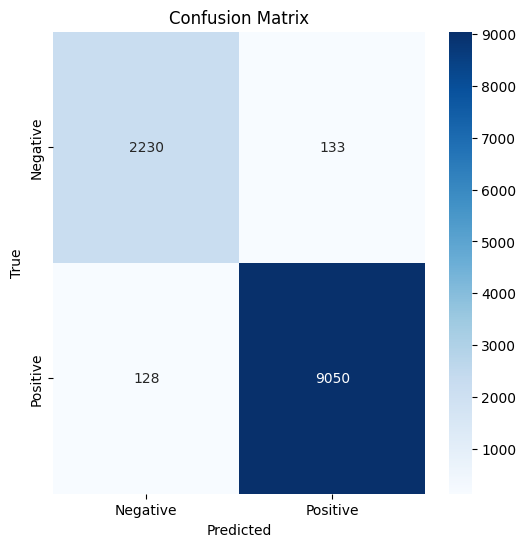

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

In [ ]:
# Function to predict sentiment
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([clean_text(text)])
    tw = pad_sequences(tw, maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction]) 

In [ ]:
# Test the model
test_sentence1 = ""
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicted label:  positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Predicted label:  negative
